In [1]:
! pip install numpy pandas matplotlib seaborn apyori pyfpgrowth sklearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori
import pyfpgrowth
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
%matplotlib inline
%config IPCompleter.greedy=True

# Q1 - Reading Dataset

In [3]:
df = pd.read_csv('CustomerData.csv')
df.head()

,customer_id,name,gender,age,annual income (lakhs),spending score,items purchased (monthly),country,category,purchase type
0,1,Edith,Female,NaN,40.9,27,62,Iran,Baby,offline
1,2,Sinclair,Male,53.0,NaN,42,47,China,NaN,online
2,3,Enoch,Male,22.0,NaN,70,26,China,Computers,offline
3,4,Lorenzo,Male,9.0,18.5,68,80,Russia,NaN,online
4,5,Damian,Male,55.0,18.4,69,89,Philippines,Jewelery,offline


In [4]:
df.describe()

,customer_id,age,annual income (lakhs),spending score,items purchased (monthly)
count,60.000000,55.000000,52.000000,60.000000,60.000000
mean,30.500000,29.945455,35.578846,46.016667,51.333333
std,17.464249,18.669066,14.654964,26.076479,30.628815
min,1.000000,0.000000,11.200000,2.000000,1.000000
25%,15.750000,15.000000,22.225000,27.000000,25.750000
50%,30.500000,31.000000,35.150000,43.500000,57.000000
75%,45.250000,46.000000,50.325000,68.250000,75.250000
max,60.000000,59.000000,60.000000,100.000000,100.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
customer_id                  60 non-null int64
name                         60 non-null object
gender                       50 non-null object
age                          55 non-null float64
annual income (lakhs)        52 non-null float64
spending score               60 non-null int64
items purchased (monthly)    60 non-null int64
country                      60 non-null object
category                     47 non-null object
purchase type                60 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 4.8+ KB


In [6]:
df.rename(columns =
          {
              'annual income (lakhs)':'income',
              'spending score':'score',
              'items purchased (monthly)':'items',
              'purchase type ':'type'
          },
          inplace=True
         )
df.type = df.type.map({'offline':0, 'online':1})

In [7]:
df.head()

,customer_id,name,gender,age,income,score,items,country,category,type
0,1,Edith,Female,NaN,40.9,27,62,Iran,Baby,0
1,2,Sinclair,Male,53.0,NaN,42,47,China,NaN,1
2,3,Enoch,Male,22.0,NaN,70,26,China,Computers,0
3,4,Lorenzo,Male,9.0,18.5,68,80,Russia,NaN,1
4,5,Damian,Male,55.0,18.4,69,89,Philippines,Jewelery,0


In [8]:
df.isna().sum()

customer_id     0
name            0
gender         10
age             5
income          8
score           0
items           0
country         0
category       13
type            0
dtype: int64

# Q2 - Preprocessing and Visualization

In [9]:
df.gender.fillna(df.gender.mode()[0], inplace=True)
df.age.fillna(df.age.mean(), inplace=True)
df.category.fillna(df.category.mode()[0], inplace=True)
df.income.fillna(df.income.median(), inplace=True)
df.isna().sum()

customer_id    0
name           0
gender         0
age            0
income         0
score          0
items          0
country        0
category       0
type           0
dtype: int64

In [10]:
df.drop('customer_id', axis=1, inplace=True)
df.head()

,name,gender,age,income,score,items,country,category,type
0,Edith,Female,29.945455,40.90,27,62,Iran,Baby,0
1,Sinclair,Male,53.000000,35.15,42,47,China,Beauty,1
2,Enoch,Male,22.000000,35.15,70,26,China,Computers,0
3,Lorenzo,Male,9.000000,18.50,68,80,Russia,Beauty,1
4,Damian,Male,55.000000,18.40,69,89,Philippines,Jewelery,0


In [11]:
encode = LabelEncoder()
df.age = pd.cut(df.age, bins = [0, 10, 18, 60], include_lowest=True, labels=['Kids', 'Teens', 'OldAge'])
df[['gender', 'age', 'type', 'category']] = df[['gender', 'age', 'type', 'category']].apply(encode.fit_transform)

In [12]:
df.nunique()

name        60
gender       2
age          3
income      52
score       49
items       47
country     23
category    19
type         2
dtype: int64

In [13]:
df.head()

,name,gender,age,income,score,items,country,category,type
0,Edith,0,1,40.90,27,62,Iran,1,0
1,Sinclair,1,1,35.15,42,47,China,2,1
2,Enoch,1,1,35.15,70,26,China,5,0
3,Lorenzo,1,0,18.50,68,80,Russia,2,1
4,Damian,1,1,18.40,69,89,Philippines,12,0


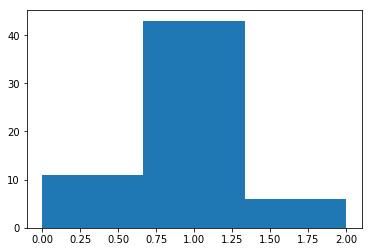

In [14]:
plt.hist(df.age, bins=3, label='age')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


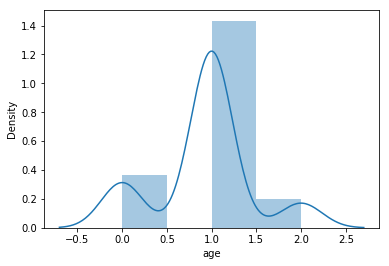

In [15]:
sns.distplot(df.age, bins=4)
plt.show()

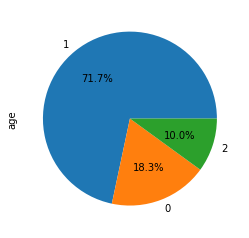

In [16]:
df.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

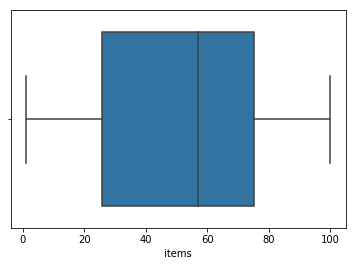

In [17]:
sns.boxplot(data=df, x='items')
plt.show()

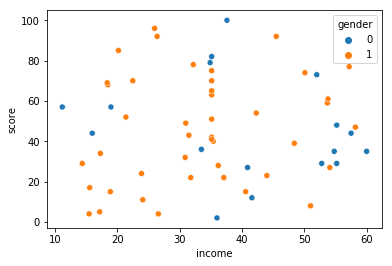

In [18]:
sns.scatterplot(data=df, x='income', y='score', hue='gender')
plt.show()

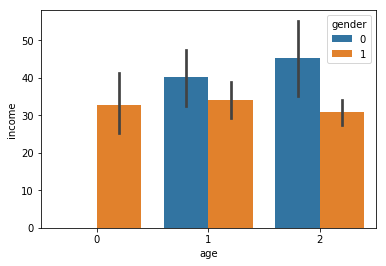

In [19]:
sns.barplot(data=df, x='age', y='income', hue='gender')

# Q3 - Association Mining - Apriori

In [20]:
def generate_record(trns):
    records = list()
    for i in range(trns.shape[0]):
        record = list()
        for j in range(len(trns.columns)):
            if trns.values[i,j]:
                record.append(trns.columns[j])
        records.append(record)
    return records

trns = pd.read_csv('association_analysis.csv')
trns.drop('tid', axis=1, inplace=True)
trns.head()

,onion,tomato,potato,bottleguard,beans
0,1,0,1,0,0
1,1,0,0,1,1
2,0,0,1,0,0
3,0,1,1,1,1
4,1,1,1,0,0


In [21]:
# itemset
records = generate_record(trns)
rules = list( apriori(records, min_support=0.03, min_confidence=0.7))
for i in rules:
    print(f'Rule: {i[0]}\nSupport: {i[1]}\nConfidence: {i[2][0][2]}\n')

Rule: frozenset({'tomato', 'beans', 'bottleguard'})
Support: 0.19607843137254902
Confidence: 0.7692307692307693

Rule: frozenset({'potato', 'tomato', 'beans'})
Support: 0.1568627450980392
Confidence: 0.7272727272727272

Rule: frozenset({'potato', 'tomato', 'beans', 'bottleguard'})
Support: 0.09803921568627451
Confidence: 0.8333333333333334

Rule: frozenset({'potato', 'tomato', 'beans', 'onion'})
Support: 0.09803921568627451
Confidence: 0.7142857142857142

Rule: frozenset({'potato', 'tomato', 'onion', 'bottleguard'})
Support: 0.09803921568627451
Confidence: 0.7142857142857142

Rule: frozenset({'onion', 'bottleguard', 'potato', 'tomato', 'beans'})
Support: 0.058823529411764705
Confidence: 0.75



# Q4 - FPGrowth

In [22]:
records = generate_record(pd.read_csv('association_analysis.csv').drop('tid', axis=1))
itemsets = pyfpgrowth.find_frequent_patterns(records, 0.03)
rules = pyfpgrowth.generate_association_rules(itemsets, 0.7)

In [23]:
itemsets

{('beans', 'bottleguard', 'onion'): 6,
 ('beans', 'bottleguard', 'onion', 'potato'): 4,
 ('bottleguard', 'onion', 'tomato'): 6,
 ('bottleguard', 'onion', 'potato', 'tomato'): 5,
 ('beans', 'bottleguard', 'onion', 'tomato'): 3,
 ('beans', 'bottleguard', 'onion', 'potato', 'tomato'): 3,
 ('bottleguard', 'onion', 'potato'): 7,
 ('beans', 'bottleguard', 'potato'): 6,
 ('beans', 'bottleguard', 'potato', 'tomato'): 5,
 ('bottleguard', 'potato', 'tomato'): 8,
 ('beans', 'bottleguard'): 13,
 ('beans', 'bottleguard', 'tomato'): 10,
 ('bottleguard', 'tomato'): 14,
 ('beans', 'onion', 'potato'): 7,
 ('beans', 'onion', 'potato', 'tomato'): 5,
 ('beans', 'potato', 'tomato'): 8,
 ('beans', 'onion'): 13,
 ('beans', 'onion', 'tomato'): 7,
 ('beans', 'tomato'): 16,
 ('onion',): 26,
 ('onion', 'tomato'): 15,
 ('onion', 'potato'): 14,
 ('onion', 'potato', 'tomato'): 9,
 ('potato', 'tomato'): 15,
 ('tomato',): 29}

In [24]:
rules

{('bottleguard', 'onion', 'potato'): (('tomato',), 0.7142857142857143),
 ('bottleguard', 'onion', 'tomato'): (('potato',), 0.8333333333333334),
 ('beans', 'bottleguard', 'onion', 'potato'): (('tomato',), 0.75),
 ('beans', 'bottleguard', 'onion', 'tomato'): (('potato',), 1.0),
 ('beans', 'bottleguard', 'potato'): (('tomato',), 0.8333333333333334),
 ('beans', 'bottleguard'): (('tomato',), 0.7692307692307693),
 ('bottleguard', 'tomato'): (('beans',), 0.7142857142857143),
 ('beans', 'onion', 'potato'): (('tomato',), 0.7142857142857143),
 ('beans', 'onion', 'tomato'): (('potato',), 0.7142857142857143)}

# Q5 - Model - Classifier

In [25]:
features = df[['gender', 'income']]
target = df['type']
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=0, test_size=0.3)

0.5
Confusion Matrix
[[2 7]
 [2 7]]
              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.50      0.78      0.61         9

   micro avg       0.50      0.50      0.50        18
   macro avg       0.50      0.50      0.46        18
weighted avg       0.50      0.50      0.46        18



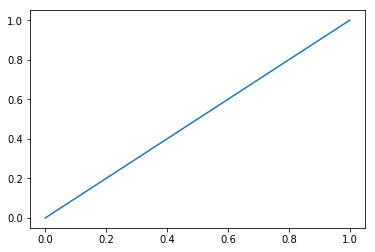

In [26]:
# Decision Tree
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)

print(model.score(x_test, y_test))

print(f"Confusion Matrix\n{metrics.confusion_matrix(y_test, pred)}")
print(metrics.classification_report(y_test, pred))
roc = metrics.roc_curve(y_test, pred)
sns.lineplot(x=roc[0], y=roc[1])
plt.show()

# Q6 - Model - Ensemble

0.5
Confusion Matrix
[[3 6]
 [3 6]]
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.50      0.67      0.57         9

   micro avg       0.50      0.50      0.50        18
   macro avg       0.50      0.50      0.49        18
weighted avg       0.50      0.50      0.49        18



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


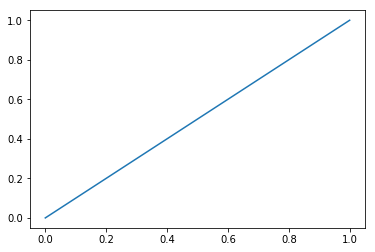

In [27]:
# RandomForest
del model
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(f"Confusion Matrix\n{metrics.confusion_matrix(y_test, pred)}")
print(metrics.classification_report(y_test, pred))
roc = metrics.roc_curve(y_test, pred)
sns.lineplot(x=roc[0], y=roc[1])
plt.show()

0.5
Confusion Matrix
[[2 7]
 [2 7]]
              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.50      0.78      0.61         9

   micro avg       0.50      0.50      0.50        18
   macro avg       0.50      0.50      0.46        18
weighted avg       0.50      0.50      0.46        18



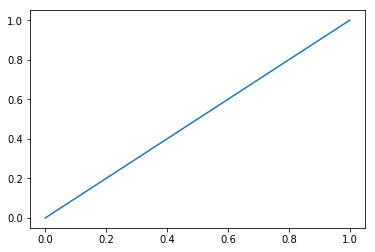

In [28]:
del model
model = AdaBoostClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(f"Confusion Matrix\n{metrics.confusion_matrix(y_test, pred)}")
print(metrics.classification_report(y_test, pred))
roc = metrics.roc_curve(y_test, pred)
sns.lineplot(x=roc[0], y=roc[1])
plt.show()

0.5
Confusion Matrix
[[2 7]
 [2 7]]
              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.50      0.78      0.61         9

   micro avg       0.50      0.50      0.50        18
   macro avg       0.50      0.50      0.46        18
weighted avg       0.50      0.50      0.46        18



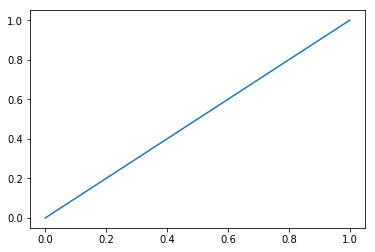

In [29]:
del model
model = BaggingClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(f"Confusion Matrix\n{metrics.confusion_matrix(y_test, pred)}")
print(metrics.classification_report(y_test, pred))
roc = metrics.roc_curve(y_test, pred)
sns.lineplot(x=roc[0], y=roc[1])
plt.show()

# Q7 - KMeans

-1142.4096823045265
Confusion Matrix
[[5 4]
 [7 2]]
              precision    recall  f1-score   support

           0       0.42      0.56      0.48         9
           1       0.33      0.22      0.27         9

   micro avg       0.39      0.39      0.39        18
   macro avg       0.38      0.39      0.37        18
weighted avg       0.38      0.39      0.37        18



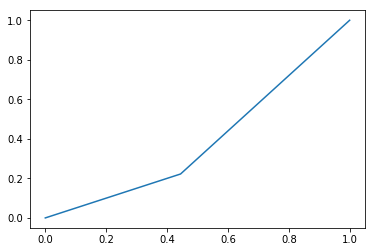

In [30]:
model = KMeans(n_clusters=2, random_state=0)
model.fit(x_train, y_train)
pred = model.predict(x_test)
print(model.score(x_test, y_test))
print(f"Confusion Matrix\n{metrics.confusion_matrix(y_test, pred)}")
print(metrics.classification_report(y_test, pred))
roc = metrics.roc_curve(y_test, pred)
sns.lineplot(x=roc[0], y=roc[1])
plt.show()

# Q8 - Density Based Clustering

In [31]:
df.head()

,name,gender,age,income,score,items,country,category,type
0,Edith,0,1,40.90,27,62,Iran,1,0
1,Sinclair,1,1,35.15,42,47,China,2,1
2,Enoch,1,1,35.15,70,26,China,5,0
3,Lorenzo,1,0,18.50,68,80,Russia,2,1
4,Damian,1,1,18.40,69,89,Philippines,12,0


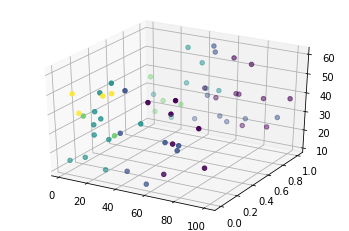

In [32]:
model = AgglomerativeClustering(n_clusters=5)
clust = model.fit_predict(df[['gender', 'category', 'type', 'score', 'income', 'items']])

from mpl_toolkits.mplot3d import Axes3D 
ax = plt.axes(projection='3d')
plt.axes(projection='3d').scatter3D(df.score, df.type, df.income,c=clust,cmap='viridis')